Downloading a Kaggle dataset in Google Colaboratory

Kaggle makes available an easy-to-use API to programmatically download Kagglehosted datasets. You can use it to download the Dogs vs. Cats dataset to a Colab
notebook, for instance.

This API is available as the kaggle package, which is preinstalled on Colab. Downloading this dataset is as easy as running the following command in a Colab cell:

In [ ]:
!kaggle competitions download -c dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


However, access to the API is restricted to Kaggle users, so in order to run the preceding command, you first need to authenticate yourself. The kaggle package will
look for your login credentials in a JSON file located at ~/.kaggle/kaggle.json. Let’s
create this file.

First, you need to create a Kaggle API key and download it to your local machine. Just
navigate to the Kaggle website in a web browser, log in, and go to the My Account
page. In your account settings, you’ll find an API section. Clicking the Create New API
Token button will generate a kaggle.json key file and will download it to your machine.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jayshah1234","key":"b5a70f58d9814ed536fb83b549b26d2c"}'}

Finally, create a ~/.kaggle folder (mkdir ~/.kaggle), and copy the key file to it
(cp kaggle.json ~/.kaggle/). As a security best practice, you should also make
sure that the file is only readable by the current user, yourself (chmod 600)

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

You can now download the data we’re about to use:


In [3]:
!kaggle competitions download -c dogs-vs-cats

 99% 807M/812M [00:08<00:00, 111MB/s]
100% 812M/812M [00:08<00:00, 105MB/s]


The first time you try to download the data, you may get a “403 Forbidden” error.
That’s because you need to accept the terms associated with the dataset before you
download it—you’ll have to go to www.kaggle.com/c/dogs-vs-cats/rules (while
logged into your Kaggle account) and click the I Understand and Accept button. You
only need to do this once.

Finally, the training data is a compressed file named train.zip. Make sure you uncompress it (unzip) silently (-qq)

In [4]:
!unzip -qq dogs-vs-cats.zip

 The subsampled dataset we will work with will have the following directory structure:
cats_vs_dogs_small/

...train/

......cat/

......dog/

...validation/

......cat/

......dog/

...test/

......cat/

......dog/

In [5]:
train_zip_path = '/content/train.zip'
test_zip_path = '/content/test1.zip'

# Specify the extraction paths
train_extract_path = '/content/dogs-vs-cats/train'
test_extract_path = '/content/dogs-vs-cats/test'

# Create extraction directories if they do not exist
!mkdir -p {train_extract_path}
!mkdir -p {test_extract_path}

# Unzip the train and test files
!unzip -qq {train_zip_path} -d {train_extract_path}
!unzip -qq {test_zip_path} -d {test_extract_path}

In [6]:
from pathlib import Path
import os
import shutil

def make_subset(subset_name, start_index, end_index):
    new_base_dir = Path('/content/cats_vs_dogs_small')
    original_dir = Path('/content/dogs-vs-cats/train/train')

    for category in ("cat", "dog"):
        dir_path = new_base_dir / subset_name / category
        os.makedirs(dir_path, exist_ok=True)

        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]

        for fname in fnames:
            src_path = original_dir / fname
            dst_path = dir_path / fname
            shutil.copyfile(src=src_path, dst=dst_path)

# Example usage:
make_subset("train", 0, 1000)
make_subset("validation", 1000, 1500)
make_subset("test", 1500, 2500)


We now have 2,000 training images, 1,000 validation images, and 2,000 test images.
Each split contains the same number of samples from each class: this is a balanced
binary-classification problem, which means classification accuracy will be an appropriate measure of success.

Because we’re looking at a binary-classification problem, we’ll end the model with a
single unit (a Dense layer of size 1) and a sigmoid activation. This unit will encode the
probability that the model is looking at one class or the other.

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In a Conv2D layer, the number of parameters can be calculated as follows:

Number of Parameters
=
(
kernel_size_height
×
kernel_size_width
×
input_channels
+
1
)
×
number_of_filters


Here's how the parameters are calculated in your specific example:

kernel_size: Assuming the default kernel size is used, which is typically 3x3 in many implementations.
input_channels: This is the number of channels in the input data. In your case, it's 3, as indicated by the (None, 180, 180, 3) shape of your input.
number_of_filters: This is the number of filters in the convolutional layer. In your case, it's 32.

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [ ]:
model.compile(loss="binary_crossentropy",
 optimizer="rmsprop",
 metrics=["accuracy"])

 data should be formatted into appropriately preprocessed floatingpoint tensors before being fed into the model. Currently, the data sits on a drive as
JPEG files, so the steps for getting it into the model are roughly as follows:

1 Read the picture files.

2 Decode the JPEG content to RGB grids of pixels.

3 Convert these into floating-point tensors.

4 Resize them to a shared size (we’ll use 180 × 180).

5 Pack them into batches (we’ll use batches of 32 images).

It may seem a bit daunting, but fortunately Keras has utilities to take care of these steps
automatically. In particular, Keras features the utility function image_dataset_from_
directory(), which lets you quickly set up a data pipeline that can automatically turn
image files on disk into batches of preprocessed tensors. This is what we’ll use here.

Calling image_dataset_from_directory(directory) will first list the subdirectories of directory and assume each one contains images from one of our classes. It will
then index the image files in each subdirectory. Finally, it will create and return a
tf.data.Dataset object configured to read these files, shuffle them, decode them to
tensors, resize them to a shared size, and pack them into batches.


In [10]:
import os, shutil, pathlib
new_base_dir = pathlib.Path("cats_vs_dogs_small")
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory( new_base_dir / "train", image_size=(180, 180),batch_size=32)
validation_dataset = image_dataset_from_directory(new_base_dir / "validation",image_size=(180, 180),batch_size=32)
test_dataset = image_dataset_from_directory(new_base_dir / "test",image_size=(180, 180),batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [11]:
for data_batch, labels_batch in train_dataset:
 print("data batch shape:", data_batch.shape)
 print("labels batch shape:", labels_batch.shape)
 break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Note that we’ll also use a ModelCheckpoint callback to save the model after each
epoch. We’ll configure it with the path specifying where to save the file, as well as the
arguments save_best_only=True and monitor="val_loss": they tell the callback to
only save a new file (overwriting any previous one) when the current value of the
val_loss metric is lower than at any previous time during training.

This guarantees
that your saved file will always contain the state of the model corresponding to its bestperforming training epoch, in terms of its performance on the validation data.

In [ ]:
callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="convnet_from_scratch.keras",
 save_best_only=True,
 monitor="val_loss")
]

In [ ]:
history = model.fit(
 train_dataset,
 epochs=30,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 12s 84ms/step - loss: 0.7180 - accuracy: 0.4970 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 6s 86ms/step - loss: 0.6948 - accuracy: 0.5325 - val_loss: 0.7000 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 4s 62ms/step - loss: 0.6926 - accuracy: 0.5415 - val_loss: 0.6971 - val_accuracy: 0.5000
Epoch 4/30
63/63 [==============================] - 5s 74ms/step - loss: 0.6984 - accuracy: 0.5660 - val_loss: 0.6742 - val_accuracy: 0.6010
Epoch 5/30
63/63 [==============================] - 4s 57ms/step - loss: 0.6748 - accuracy: 0.6030 - val_loss: 0.6486 - val_accuracy: 0.6190
Epoch 6/30
63/63 [==============================] - 4s 57ms/step - loss: 0.6535 - accuracy: 0.6385 - val_loss: 0.7090 - val_accuracy: 0.5740
Epoch 7/30
63/63 [==============================] - 5s 78ms/step - loss: 0.6246 - accuracy: 0.6700 - val_loss: 0.6237 - val_accuracy: 0.6620
Epoch 8/30
6

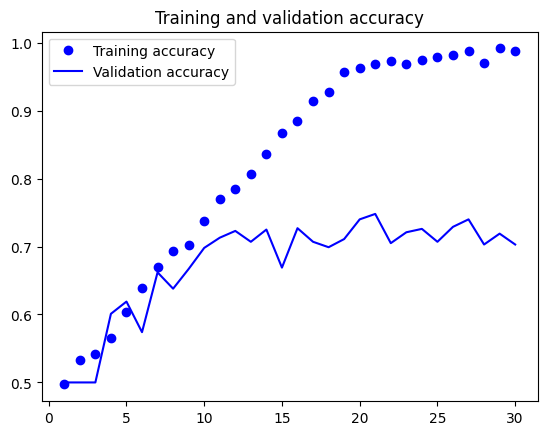

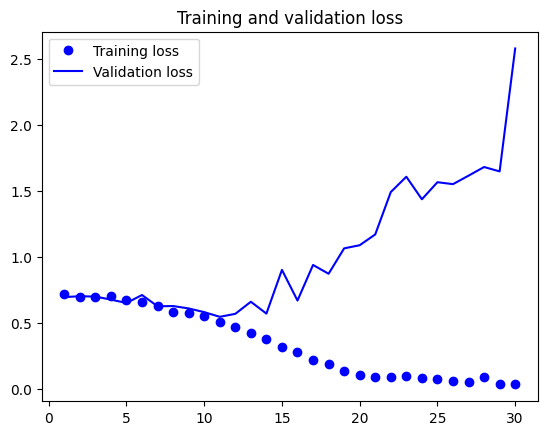

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 43ms/step - loss: 0.5592 - accuracy: 0.7230
Test accuracy: 0.723


Overfitting is caused by having too few samples to learn from, rendering you unable
to train a model that can generalize to new data. Given infinite data, your model
would be exposed to every possible aspect of the data distribution at hand: you would
never overfit. **Data augmentation** takes the approach of generating more training data
from existing training samples by augmenting the samples via a number of random
transformations that yield believable-looking images. The goal is that, at training time,
your model will never see the exact same picture twice. This helps expose the model
to more aspects of the data so it can generalize better

 In Keras, this can be done by adding a number of data augmentation layers at the
start of your model. Let’s get started with an example: the following Sequential model
chains several random image transformations. In our model, we’d include it right
before the Rescaling layer.

# Data Augmentation

In [12]:
# Define a data augmentation stage to add to an image model
data_augmentation = keras.Sequential(
 [
 layers.RandomFlip("horizontal"),
 layers.RandomRotation(0.1),
 layers.RandomZoom(0.2),
 ]
)


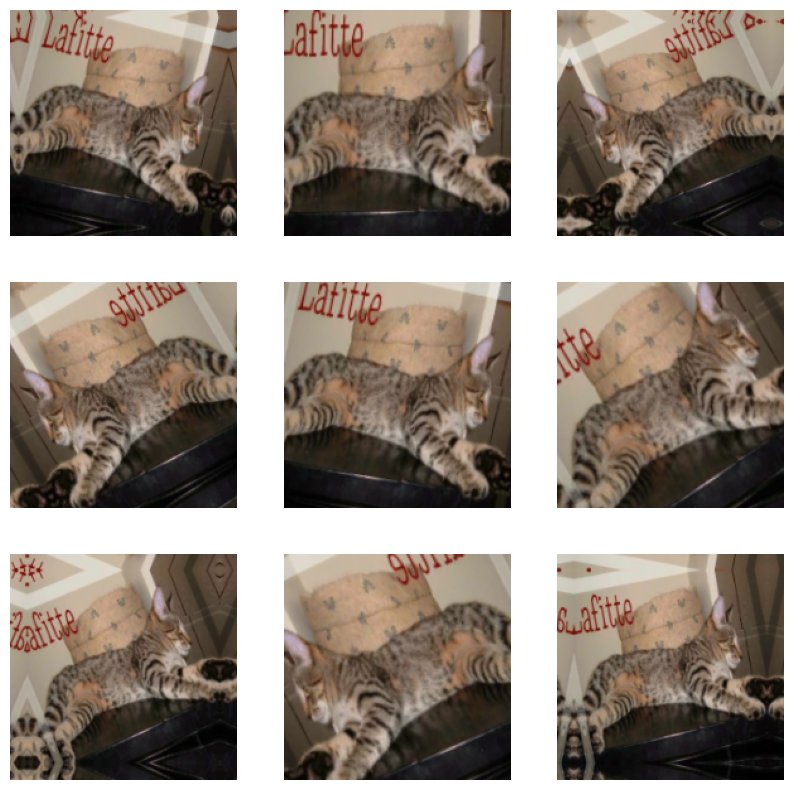

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1): # We can use take(N) to only sample N batches from the dataset. This is equivalent to inserting a break in the loop after the Nth batch.
 for i in range(9):
  augmented_images = data_augmentation(images) # Apply the augmentation stage to the batch of images.
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_images[0].numpy().astype("uint8")) # Display the first image in the output batch. For each of the nine iterations, this is a different augmentation of the same image
  plt.axis("off")

In [13]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [14]:
model.compile(loss="binary_crossentropy",
 optimizer="rmsprop",
 metrics=["accuracy"])

Let’s train the model using data augmentation and dropout. Because we expect overfitting to occur much later during training, we will train for three times as many
epochs—one hundred

In [ ]:
callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="convnet_from_scratch_with_augmentation.keras",
 save_best_only=True,
 monitor="val_loss")
]
history = model.fit(
 train_dataset,
 epochs=100,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 9s 96ms/step - loss: 0.6987 - accuracy: 0.5285 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 4s 61ms/step - loss: 0.6974 - accuracy: 0.5145 - val_loss: 0.6919 - val_accuracy: 0.5020
Epoch 3/100
63/63 [==============================] - 4s 59ms/step - loss: 0.6912 - accuracy: 0.5380 - val_loss: 0.6980 - val_accuracy: 0.5030
Epoch 4/100
63/63 [==============================] - 7s 100ms/step - loss: 0.6864 - accuracy: 0.5695 - val_loss: 0.7097 - val_accuracy: 0.5090
Epoch 5/100
63/63 [==============================] - 4s 61ms/step - loss: 0.6561 - accuracy: 0.6145 - val_loss: 0.7370 - val_accuracy: 0.5190
Epoch 6/100
63/63 [==============================] - 4s 64ms/step - loss: 0.6485 - accuracy: 0.6290 - val_loss: 0.6571 - val_accuracy: 0.5980
Epoch 7/100
63/63 [==============================] - 5s 67ms/step - loss: 0.6387 - accuracy: 0.6370 - val_loss: 0.6304 - val_accuracy: 0.6240
Epoch

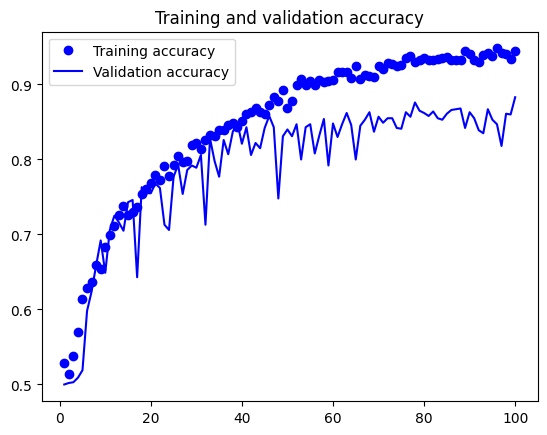

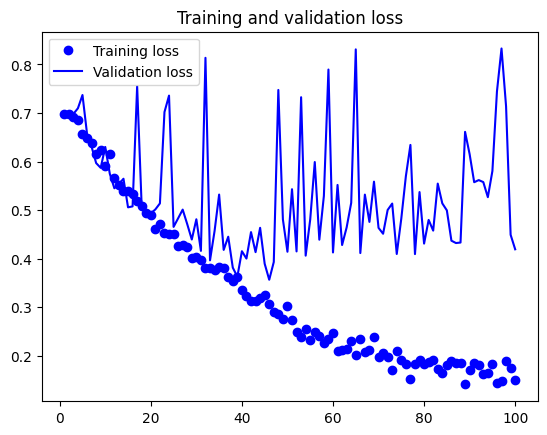

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model(
 "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 43ms/step - loss: 0.4366 - accuracy: 0.8255
Test accuracy: 0.826


[Using Feature extraction on a pretarined model](https://chat.openai.com/share/3f0e537c-6cb7-4650-ba50-f22d4f67fda0)

[Different layers of convnet, what they do](https://chat.openai.com/share/a1bb1764-9ddb-4b45-bbaa-02fb6af7ea9b)

# Feature Extraction using pretrained model

Let’s put this into practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from cat and dog images, and then train a dogs-versus-cats classifier on top of
these features.

The VGG16 model, among others, comes prepackaged with Keras. You can import
it from the **keras.applications** module. Many other image-classification models (all
pretrained on the ImageNet dataset) are available as part of keras.applications:

 Xception

 ResNet

 MobileNet

 EfficientNet

 DenseNet

 etc.

In [15]:
conv_base = keras.applications.vgg16.VGG16(
 weights="imagenet",
 include_top=False,
 input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


We pass three arguments to the constructor:

 weights specifies the weight checkpoint from which to initialize the model.

 include_top refers to including (or not) the densely connected classifier on
top of the network. By default, this densely connected classifier corresponds to
the 1,000 classes from ImageNet. Because we intend to use our own densely
connected classifier (with only two classes: cat and dog), we don’t need to
include it.

 input_shape is the shape of the image tensors that we’ll feed to the network.
This argument is purely optional: if we don’t pass it, the network will be able to
process inputs of any size. Here we pass it so that we can visualize (in the following summary) how the size of the feature maps shrinks with each new convolution and pooling layer.

In [16]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

# FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION

We’ll start by extracting features as NumPy arrays by calling the predict() method of
the conv_base model on our training, validation, and testing datasets.

In [17]:
import numpy as np
def get_features_and_labels(dataset):
 all_features = []
 all_labels = []
 for images, labels in dataset:
  preprocessed_images = keras.applications.vgg16.preprocess_input(images)
  features = conv_base.predict(preprocessed_images)
  all_features.append(features)
  all_labels.append(labels)
 return np.concatenate(all_features), np.concatenate(all_labels)

In [18]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 24ms/step


Importantly, predict() only expects images, not labels, but our current dataset yields
batches that contain both images and their labels. Moreover, the VGG16 model expects
inputs that are preprocessed with the function **keras.applications.vgg16.preprocess_input**, which scales pixel values to an appropriate range.


In [19]:
 train_features.shape

(2000, 5, 5, 512)

In [20]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [21]:
model.compile(loss="binary_crossentropy",
 optimizer="rmsprop",
 metrics=["accuracy"])

In [22]:
callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="feature_extraction.keras",
 save_best_only=True,
 monitor="val_loss")
]
history = model.fit(
 train_features, train_labels,
 epochs=20,
 validation_data=(val_features, val_labels),
 callbacks=callbacks)


Epoch 1/20
63/63 [==============================] - 4s 16ms/step - loss: 17.8033 - accuracy: 0.9235 - val_loss: 3.7319 - val_accuracy: 0.9700
Epoch 2/20
63/63 [==============================] - 1s 11ms/step - loss: 4.7881 - accuracy: 0.9720 - val_loss: 3.4730 - val_accuracy: 0.9770
Epoch 3/20
63/63 [==============================] - 1s 11ms/step - loss: 2.1434 - accuracy: 0.9865 - val_loss: 3.2243 - val_accuracy: 0.9800
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 0.6032 - accuracy: 0.9960 - val_loss: 3.5236 - val_accuracy: 0.9750
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 0.6089 - accuracy: 0.9955 - val_loss: 7.0798 - val_accuracy: 0.9620
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 1.0140 - accuracy: 0.9910 - val_loss: 5.1876 - val_accuracy: 0.9750
Epoch 7/20
63/63 [==============================] - 1s 15ms/step - loss: 0.5271 - accuracy: 0.9935 - val_loss: 5.2971 - val_accuracy: 0.9710
Epoch 8/20
63/6

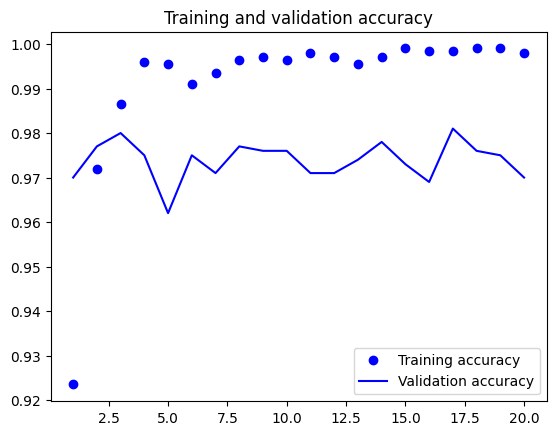

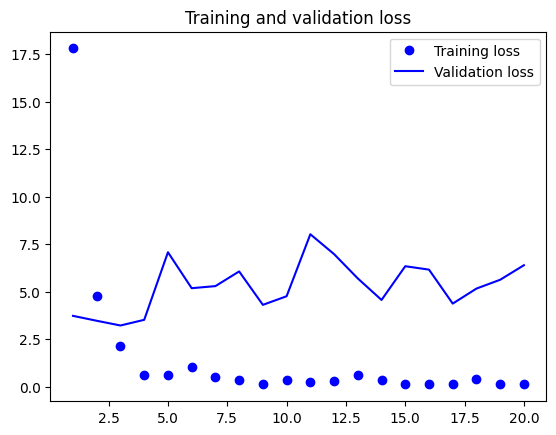

In [23]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We reach a validation accuracy of about 97%—much better than we achieved in the
previous section with the small model trained from scratch. This is a bit of an unfair
comparison, however, because ImageNet contains many dog and cat instances, which
means that our pretrained model already has the exact knowledge required for the
task at hand. This won’t always be the case when you use pretrained features.

# FEATURE EXTRACTION TOGETHER WITH DATA AUGMENTATION

 In order to do this, we will first freeze the convolutional base. Freezing a layer or set of
layers means preventing their weights from being updated during training. If we don’t
do this, the representations that were previously learned by the convolutional base will
be modified during training. Because the Dense layers on top are randomly initialized,
very large weight updates would be propagated through the network, effectively
destroying the representations previously learned.


 In Keras, we freeze a layer or model by setting its trainable attribute to False.

In [24]:
conv_base = keras.applications.vgg16.VGG16(
 weights="imagenet",
 include_top=False)
conv_base.trainable = False

Setting trainable to False empties the list of trainable weights of the layer or model.

In [25]:
conv_base.trainable = True
print("This is the number of trainable weights "
 "before freezing the conv base:", len(conv_base.trainable_weights))
conv_base.trainable = False
print("This is the number of trainable weights "
 "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


In [26]:
data_augmentation = keras.Sequential(
 [
 layers.RandomFlip("horizontal"),
 layers.RandomRotation(0.1),
 layers.RandomZoom(0.2),
 ]
)

In [27]:
import tensorflow as tf
from tensorflow.keras import layers

class CustomDataAugmentation(layers.Layer):
    def __init__(self, **kwargs):
        super(CustomDataAugmentation, self).__init__(**kwargs)

    def call(self, inputs, training=True):
        if training:
            # Apply data augmentation during training
            augmented_inputs = tf.image.random_flip_left_right(inputs)
            augmented_inputs = tf.image.random_rotation(augmented_inputs, 0.1)
            augmented_inputs = tf.image.random_zoom(augmented_inputs, (1 - 0.2, 1 + 0.2))
            return augmented_inputs
        else:
            return inputs

    def get_config(self):
        return super(CustomDataAugmentation, self).get_config()

In [28]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [29]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 180, 180, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0   

In [30]:
model.compile(loss="binary_crossentropy",
 optimizer="rmsprop",
 metrics=["accuracy"])

With this setup, only the weights from the two Dense layers that we added will be
trained. That’s a total of four weight tensors: two per layer (the main weight matrix
and the bias vector). Note that in order for these changes to take effect, you must first
compile the model. If you ever modify weight trainability after compilation, you
should then recompile the model, or these changes will be ignored.

 Let’s train our model. Thanks to data augmentation, it will take much longer for
the model to start overfitting, so we can train for more epochs—let’s do 50.

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define your callbacks
checkpoint_callback = ModelCheckpoint("model_checkpoint.h5", save_best_only=True)
early_stopping_callback = EarlyStopping(patience=5)

# Pass the callbacks as a list
callbacks_list = [checkpoint_callback, early_stopping_callback]

# Use the callbacks in model.fit
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks_list
)


Epoch 1/50
63/63 [==============================] - 12s 151ms/step - loss: 20.7426 - accuracy: 0.8950 - val_loss: 3.4311 - val_accuracy: 0.9690
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 11s 171ms/step - loss: 6.8802 - accuracy: 0.9405 - val_loss: 3.5293 - val_accuracy: 0.9750
Epoch 3/50
63/63 [==============================] - 12s 181ms/step - loss: 5.0389 - accuracy: 0.9615 - val_loss: 2.9881 - val_accuracy: 0.9730
Epoch 4/50
63/63 [==============================] - 11s 173ms/step - loss: 5.4316 - accuracy: 0.9590 - val_loss: 3.0959 - val_accuracy: 0.9730
Epoch 5/50
63/63 [==============================] - 12s 183ms/step - loss: 4.4597 - accuracy: 0.9635 - val_loss: 2.3515 - val_accuracy: 0.9760
Epoch 6/50
63/63 [==============================] - 9s 145ms/step - loss: 3.0849 - accuracy: 0.9740 - val_loss: 3.0900 - val_accuracy: 0.9770
Epoch 7/50
63/63 [==============================] - 10s 143ms/step - loss: 3.8072 - accuracy: 0.9655 - val_loss: 4.5546 - val_accuracy: 0.9710
Epoch 8/50
63/63 [==============================] - 11s 175ms/step - loss: 3.1499 - accuracy: 0.9705 - val_loss: 3.4322 - val_accuracy: 0.9760
Epoch 9/50


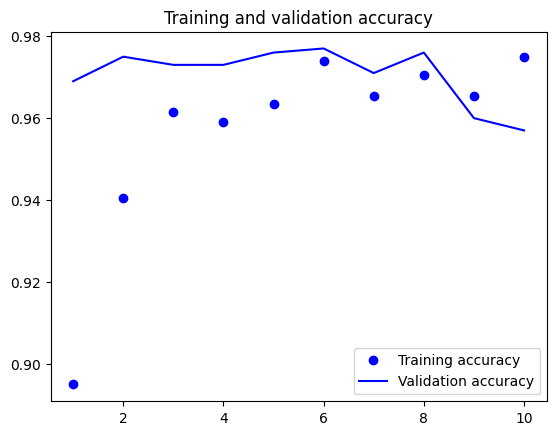

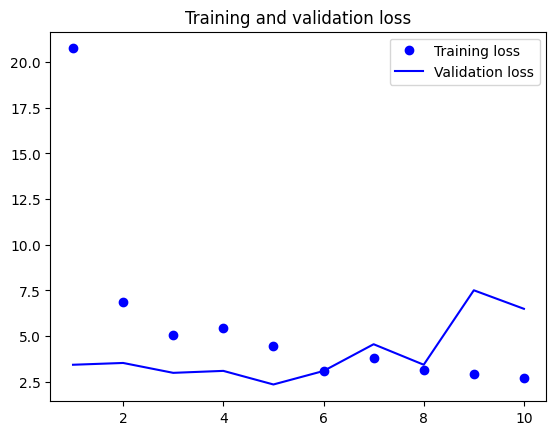

In [32]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [33]:
test_model = keras.models.load_model(
 "model_checkpoint.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 89ms/step - loss: 3.7541 - accuracy: 0.9705
Test accuracy: 0.970


# Fine-tuning a pretrained model

Fine-tuning consists of unfreezing
a few of the top layers of a frozen model base used
for feature extraction, and jointly training both the
newly added part of the model (in this case, the
fully connected classifier) and these top layers. This
is called fine-tuning because it slightly adjusts the
more abstract representations of the model being
reused in order to make them more relevant for the
problem at hand.

it’s only possible to fine-tune the top
layers of the convolutional base once the classifier on
top has already been trained. If the classifier isn’t
already trained, the error signal propagating
through the network during training will be too
large, and the representations previously learned by
the layers being fine-tuned will be destroyed.

steps for fine-tuning a network are as follows:

1 Add our custom network on top of an
already-trained base network.

2 Freeze the base network.

3 Train the part we added.

4 Unfreeze some layers in the base network.
(Note that you should not unfreeze “batch
normalization” layers, which are not relevant
here since there are no such layers in VGG16.)

5 Jointly train both these layers and the part we
added.

You already completed the first three steps when
doing feature extraction. Let’s proceed with step 4:
we’ll unfreeze our conv_base and then freeze individual layers inside it.

We’ll fine-tune the last three convolutional layers, which means all layers up to block4_
pool should be frozen, and the layers block5_conv1, block5_conv2, and block5_conv3
should be trainable.

In [34]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
 layer.trainable = False

Now we can begin fine-tuning the model. We’ll do this with the RMSprop optimizer,
using a very low learning rate. The reason for using a low learning rate is that we want to
limit the magnitude of the modifications we make to the representations of the three
layers we’re fine-tuning. Updates that are too large may harm these representations.

In [35]:
model.compile(loss="binary_crossentropy",
 optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
 metrics=["accuracy"])

In [37]:
# Define your callbacks
checkpoint_callback = ModelCheckpoint("model_checkpoint.h5", save_best_only=True)
early_stopping_callback = EarlyStopping(patience=5)

# Pass the callbacks as a list
callbacks_list = [checkpoint_callback, early_stopping_callback]

history = model.fit(
 train_dataset,
 epochs=30,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 10s 151ms/step - loss: 0.7912 - accuracy: 0.9840 - val_loss: 1.7929 - val_accuracy: 0.9830
Epoch 2/30
63/63 [==============================] - 10s 155ms/step - loss: 1.3552 - accuracy: 0.9860 - val_loss: 2.3738 - val_accuracy: 0.9740
Epoch 3/30
63/63 [==============================] - 10s 155ms/step - loss: 0.7401 - accuracy: 0.9850 - val_loss: 2.0319 - val_accuracy: 0.9780
Epoch 4/30
63/63 [==============================] - 12s 188ms/step - loss: 0.6395 - accuracy: 0.9835 - val_loss: 1.3322 - val_accuracy: 0.9810
Epoch 5/30
63/63 [==============================] - 12s 188ms/step - loss: 0.6053 - accuracy: 0.9885 - val_loss: 1.4862 - val_accuracy: 0.9800
Epoch 6/30
63/63 [==============================] - 12s 189ms/step - loss: 0.4039 - accuracy: 0.9875 - val_loss: 1.3658 - val_accuracy: 0.9820
Epoch 7/30
63/63 [==============================] - 10s 155ms/step - loss: 0.4748 - accuracy: 0.9885 - val_loss: 1.5033 - val_accuracy: 0.9780

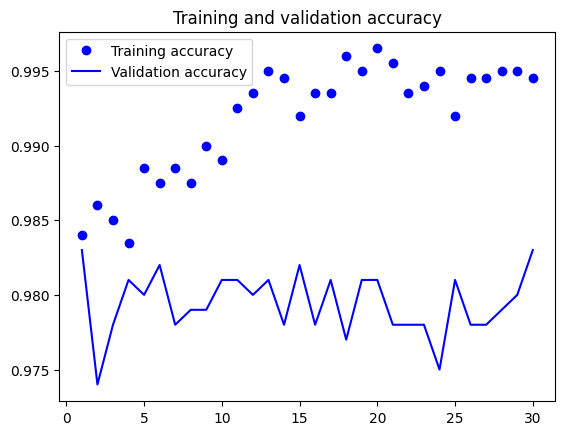

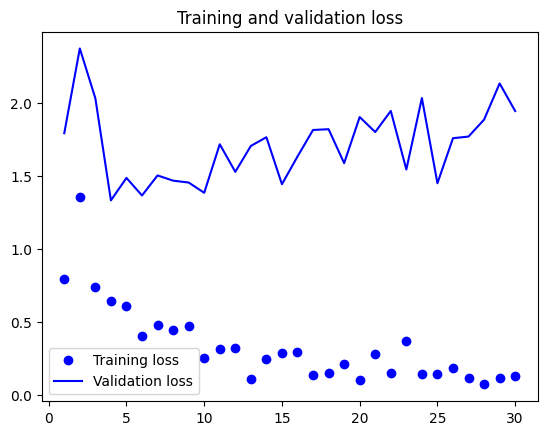

In [39]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [40]:
model = keras.models.load_model("model_checkpoint.h5")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 90ms/step - loss: 3.7541 - accuracy: 0.9705
Test accuracy: 0.970


Summary

 Convnets are the best type of machine learning models for computer vision
tasks. It’s possible to train one from scratch even on a very small dataset, with
decent results.

 Convnets work by learning a hierarchy of modular patterns and concepts to
represent the visual world.

 On a small dataset, overfitting will be the main issue. Data augmentation is a
powerful way to fight overfitting when you’re working with image data.

 It’s easy to reuse an existing convnet on a new dataset via feature extraction.
This is a valuable technique for working with small image datasets.

 As a complement to feature extraction, you can use fine-tuning, which adapts to
a new problem some of the representations previously learned by an existing
model. This pushes performance a bit further.